# Preamble

In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from eofs.xarray import Eof
from eofs.examples import example_data_path
from scipy import signal
import pandas as pd
import matplotlib
import string

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')

s2a = 365.25*24*3600

# function definitions

In [7]:
def subset_region(da,grd,rho_sel):
    da_sel = da.isel(rho_sel)
    grd_sel = grd.sel(rho_sel)
    mask_ice = (grd_sel.mask_rho == 1) & (grd_sel.zice < 0)
    da_sel = da_sel.where(mask_ice)
    return da_sel,grd_sel

def detrend(da):
    not_null = ~da[0].isnull()
    da_dt = da.copy()
    da_dt.values[:,not_null] = signal.detrend(da.values[:,not_null],axis=0)
    da_dt = da_dt - da_dt.mean('ocean_time')
    return da_dt

def make_solver(da,grd):
    dA = grd.dx[30]*grd.dy[30]
    wgts = xr.ufuncs.sqrt(dA/dA.sum())
    solver = Eof(da, weights=wgts)
    return solver

def plot_var_frac(var_frac):
    fig,ax = plt.subplots()
    var_frac.plot(ax=ax)
    ax.grid()
    plt.show()
    return

def plot_mean(axes,m):
    ax1,ax2,ax3 = axes.flatten()

    mean = m.mean().values
    std = m.std().values
    m_plt = m.mean('ocean_time').plot(ax=ax1,vmin=0-2*std,vmax=0+2*std,cmap='seismic',add_colorbar=False)
    cb = plt.colorbar(m_plt,ax=ax1,label='ustar in cm/s',extend='both')
    ax1.text(0.01, 0.9, f'Tstar {mean:.2f} $\pm$ {std:.2f}',transform=ax1.transAxes)
    ax1.set_aspect('equal')
    ax1.axis('off')

    t = pd.date_range('2007-12-30T00:30:00',periods=720,freq='H')
    #t = pd.date_range('2007-05-11T12:00:00',periods=73,freq='5D')
    ax2.plot(t,m.mean(('xi_rho','eta_rho')))
    ax2.set_ylabel('ustar in cm/s')
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d/%b'))
    ax2.grid()
    ax2.text(0.01, 0.9, 'Area-averaged ustar',transform=ax2.transAxes)


    freqs, psd = signal.welch(m.mean(('xi_rho','eta_rho')).values)

    ax3.semilogx(1/freqs, psd)
    #ax3.set_title('PSD: power spectral density')
    ax3.set_xlabel('Period in days')
    ax3.set_ylabel('Power')
    ax3.grid()
    
    return ax1,ax2,ax3

def plot_eof(axes,mode,eofs,pcs,var_frac):
    ax1,ax2,ax3 = axes.flatten()
    
    vmax = max(eofs[0].max(),-eofs[0].min())
    eof_plt = ax1.pcolormesh(eofs[mode],cmap='PRGn',vmax=vmax,vmin=-vmax)
    cb = plt.colorbar(eof_plt,ax=ax1)
    ax1.text(0.1, 0.9, f'Mode {mode}, {var_frac[mode].values*100:.2f}%', transform=ax1.transAxes)
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    t = pd.date_range('2007-12-30T00:30:00',periods=720,freq='H')
    #t = pd.date_range('2007-05-11T12:00:00',periods=73,freq='5D')
    ax2.plot(t,pcs[:,mode])
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d/%b'))
    ax2.grid()
    ax2.text(0.01, 0.9, f'PC {mode}',transform=ax2.transAxes)
    
    freqs, psd = signal.welch(pcs[:,mode])


    ax3.semilogx(1/freqs, psd)
    #ax3.set_title('PSD: power spectral density')
    ax3.set_xlabel('Period in days')
    ax3.set_ylabel('Power')
    ax3.grid()
    
    return ax1,ax2,ax3

def make_eof(da,grd,rho_sel,name):
    
    print('subsetting')
    da_sel,grd_sel = subset_region(da,grd,rho_sel)
    print('detrending')
    da_dt = detrend(da_sel)
    print('creating the eof solver')
    solver = make_solver(da_dt,grd_sel)
    
    print('calculating and plotting the variance fractions')
    var_frac = solver.varianceFraction(neigs=15)
    plot_var_frac(var_frac)
    
    print('calculating the eofs and pcs')
    eofs = solver.eofsAsCorrelation(neofs=6)
    pcs = solver.pcs(npcs=6)
    
    print('plotting')
    fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(11.69,8.27),gridspec_kw={'width_ratios': [2,3, 1]})

    axes[0,:] = plot_mean(axes[0,:],da_sel)
    axes[1,:] = plot_eof(axes[1,:],0,eofs,pcs,var_frac)
    axes[2,:] = plot_eof(axes[2,:],1,eofs,pcs,var_frac)
    
    n=0
    for ax in axes.flatten():
        ax.text(-0.1, -0.1, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=12)
        n+=1

    plt.tight_layout()
    plt.show()
    
    print('saving')
    out_path = os.path.join(fig_dir,name+'eof.png')
    fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
    
    return

# 30 days hourly samples (4 km) - sample shelves

In [3]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
avg_hr = xr.open_dataset(file_path)
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

In [5]:
sel1 = {'xi_rho':slice(714,1243),'eta_rho':slice(1408,1875)} #FRIS
sel2 = {'xi_rho':slice(1185,1726),'eta_rho':slice(652,1146)} #Ross
sel7 = {'xi_rho':slice(1429,1555),'eta_rho':slice(2338,2476)} # Fimbul
sel8 = {'xi_rho':slice(335,514),'eta_rho':slice(1850,2010)} # LarsenC
sel9 = {'xi_rho':slice(390,650),'eta_rho':slice(1580,1775)} # GeorgeV
sel10 = {'xi_rho':slice(686,720),'eta_rho':slice(1175,1220)} # PI
sel11 = {'xi_rho':slice(2570,2660),'eta_rho':slice(650,860)} # Totten
sel12 = {'xi_rho':slice(2330,2630),'eta_rho':slice(1650,1770)} # Amery

sels = {'FRIS':sel1,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,'Amery':sel12,'Fimbul':sel7,'LarsenC':sel8}
for name,sel in sels.items():
    
    sels[name]['xi_rho'] = slice(int(sel['xi_rho'].start/2),int(sel['xi_rho'].stop/2))
    sels[name]['eta_rho'] = slice(int(sel['eta_rho'].start/2),int(sel['eta_rho'].stop/2))

## melting

FRIS
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


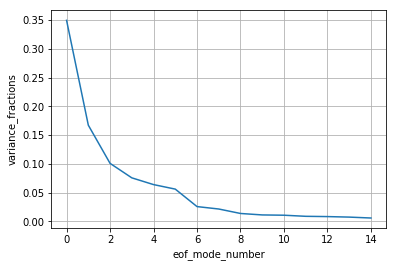

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


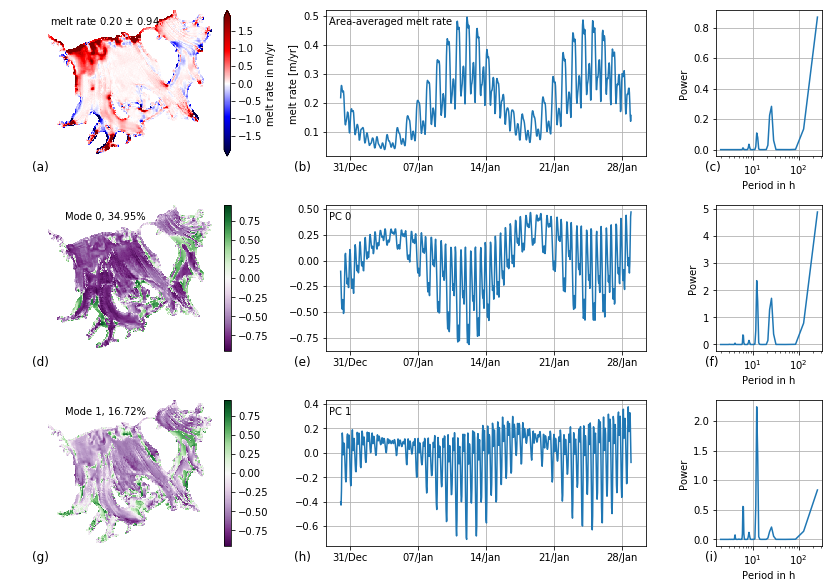

saving
Ross
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


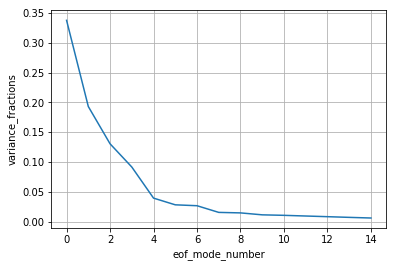

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


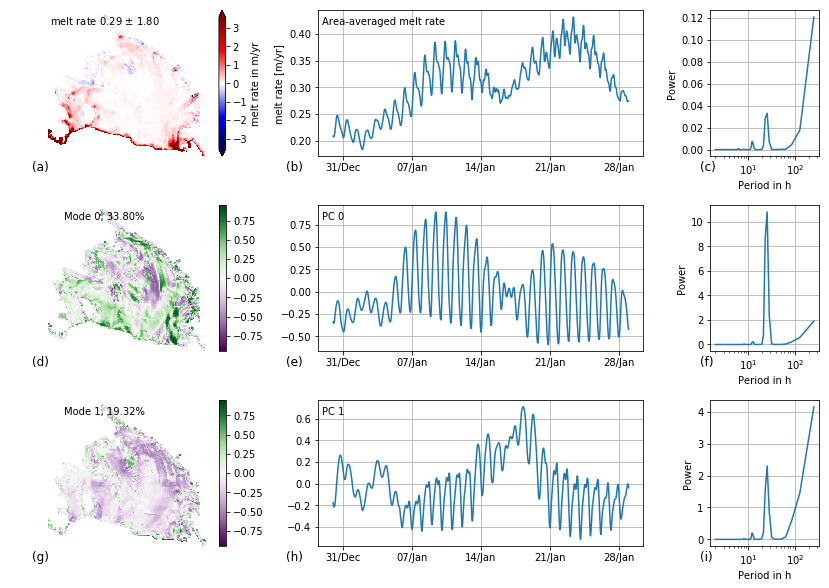

saving
GeorgeV
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


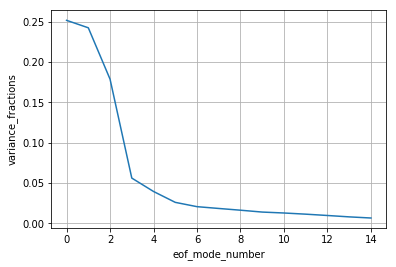

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


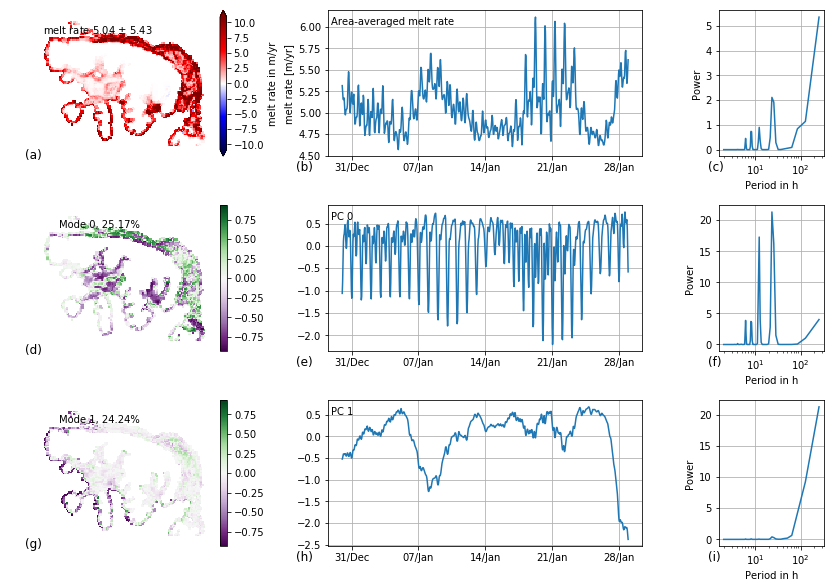

saving
PI
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


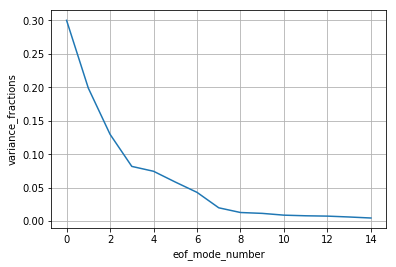

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


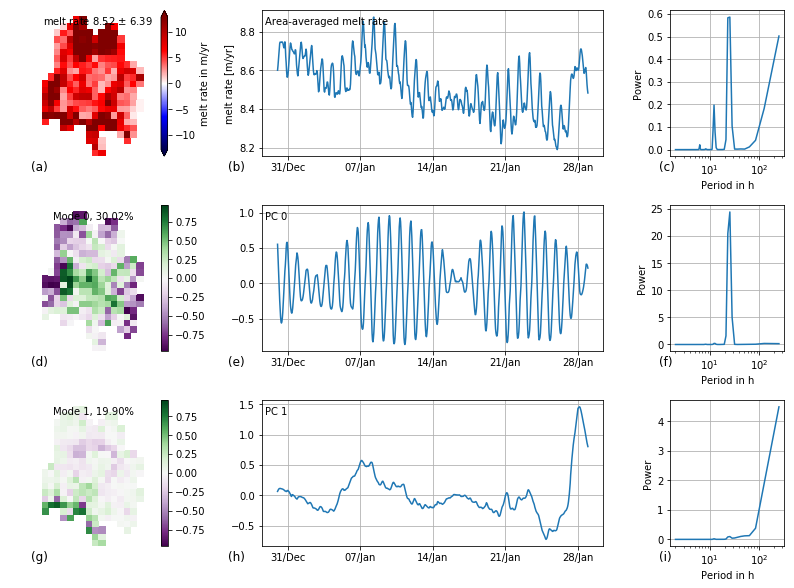

saving
Totten
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


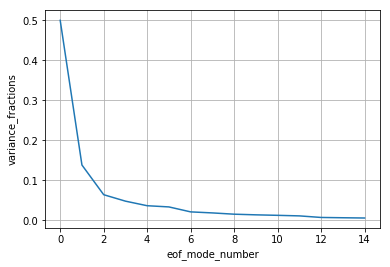

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


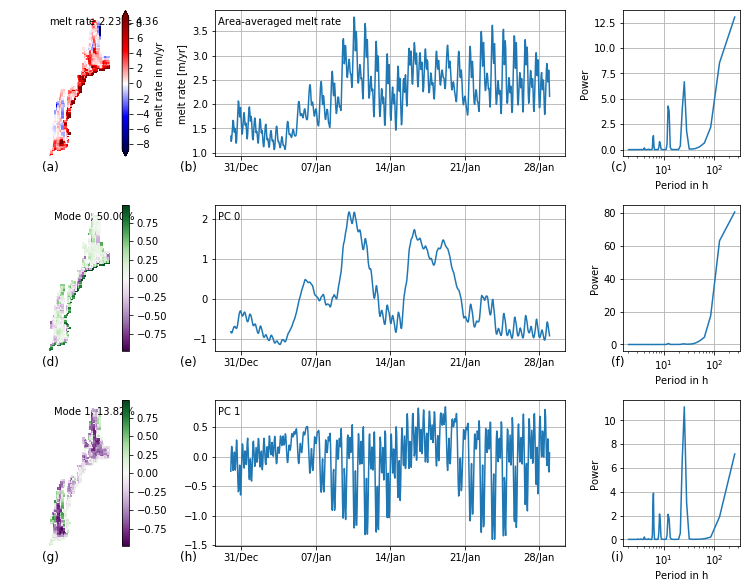

saving
Amery
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


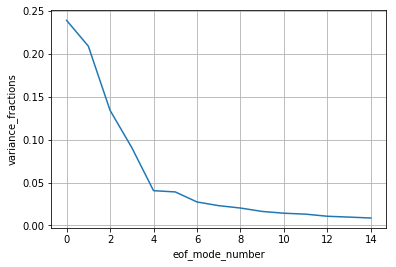

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


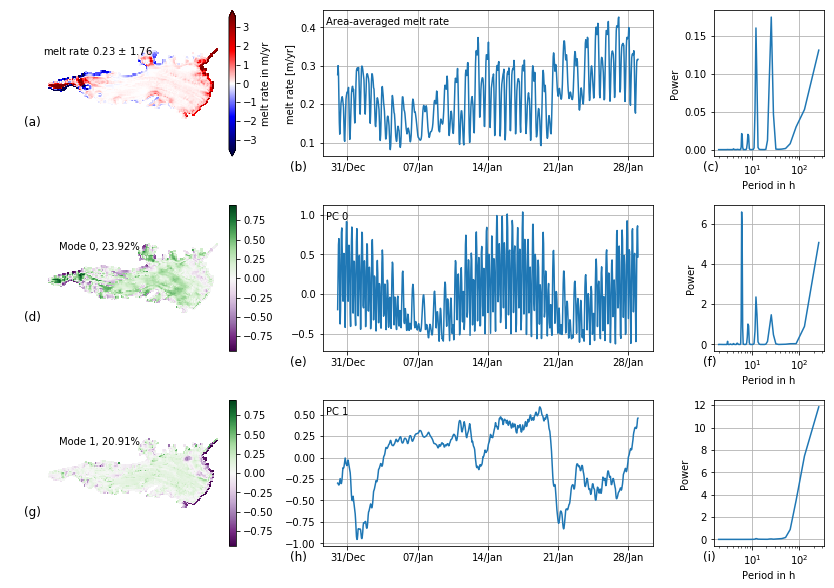

saving
Fimbul
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


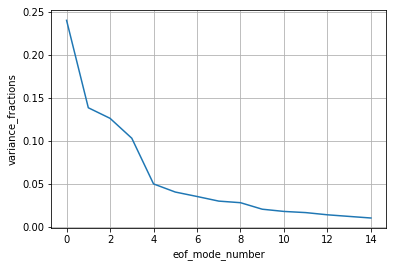

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


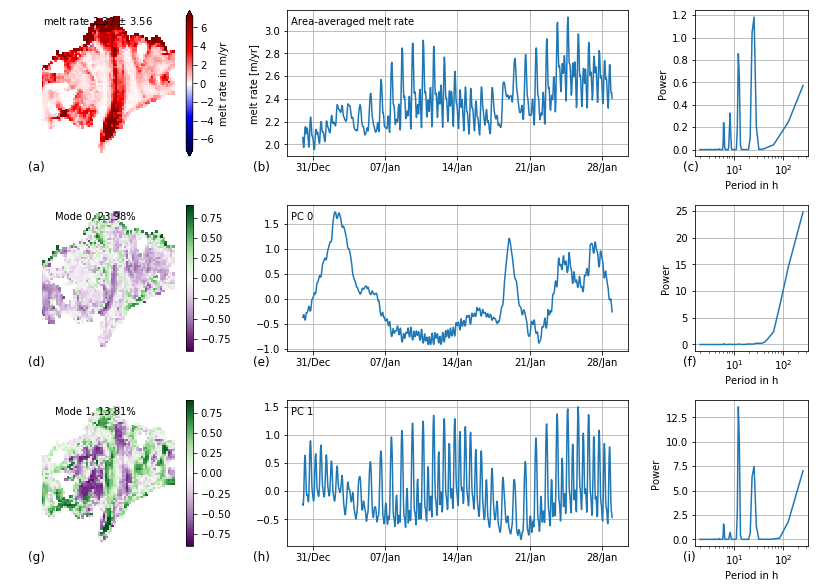

saving
LarsenC
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


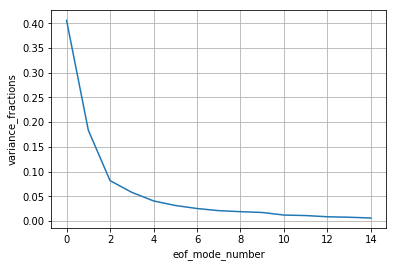

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


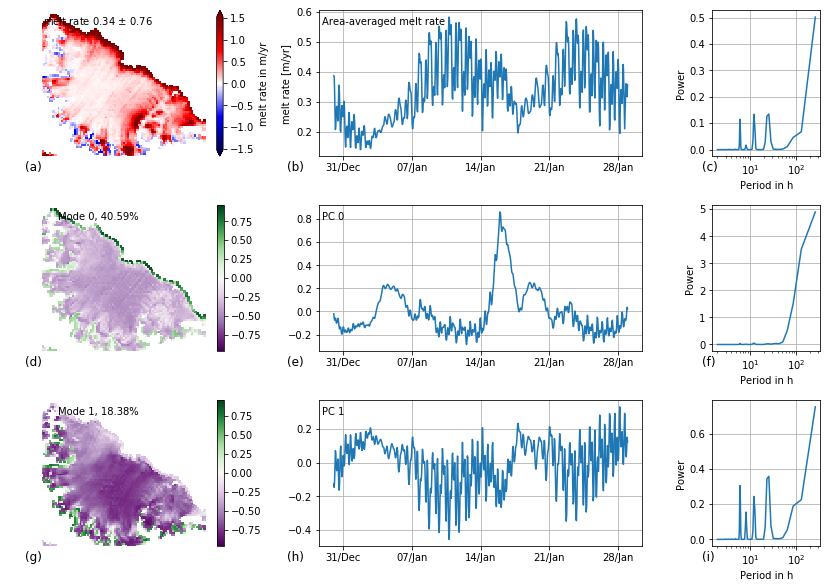

saving


In [11]:
for name,sel in sels.items():
    print(name)
    make_eof(avg_hr.m*s2a,grd,sel,name)

## Tstar

FRIS
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


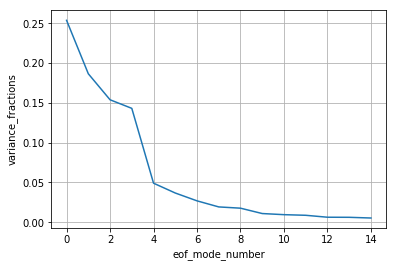

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


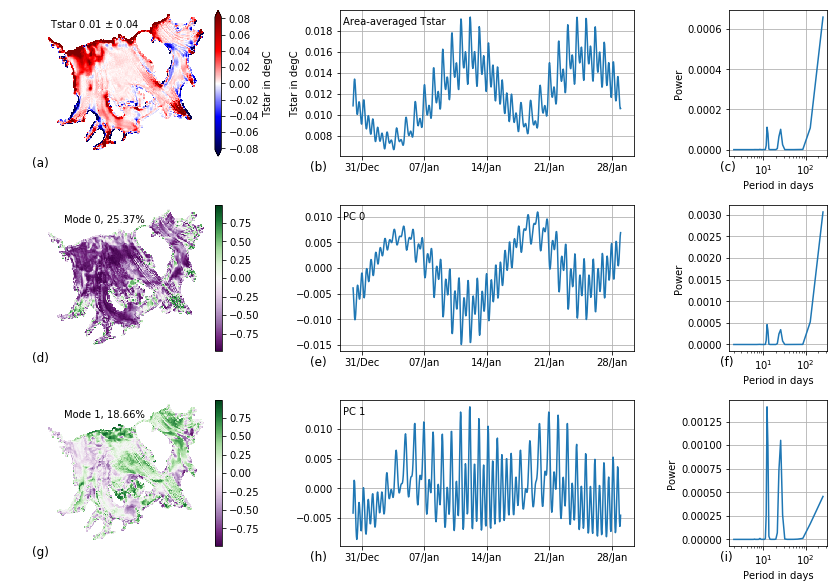

saving
Ross
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


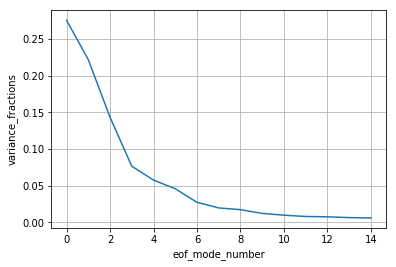

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


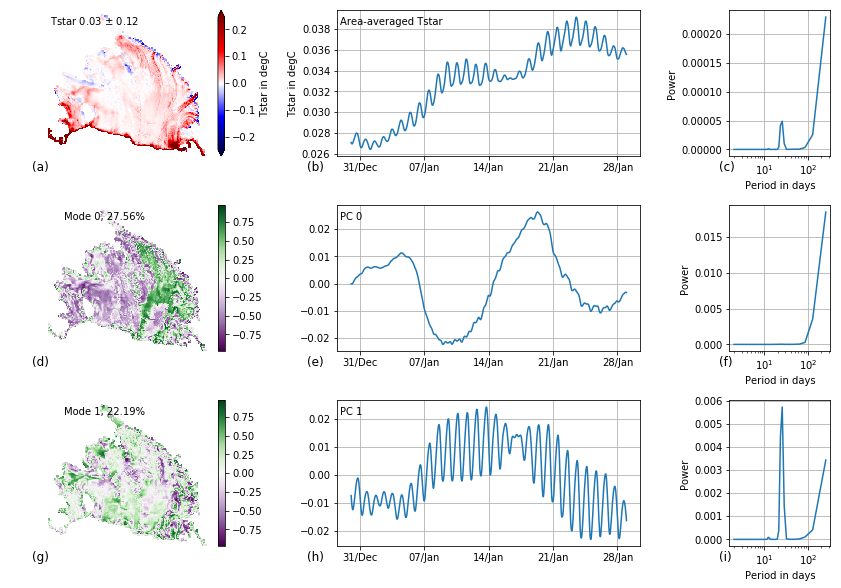

saving
GeorgeV
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


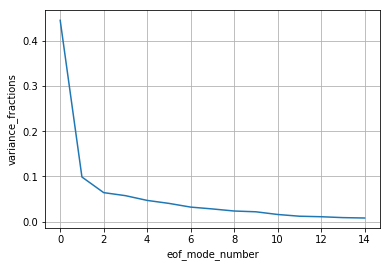

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


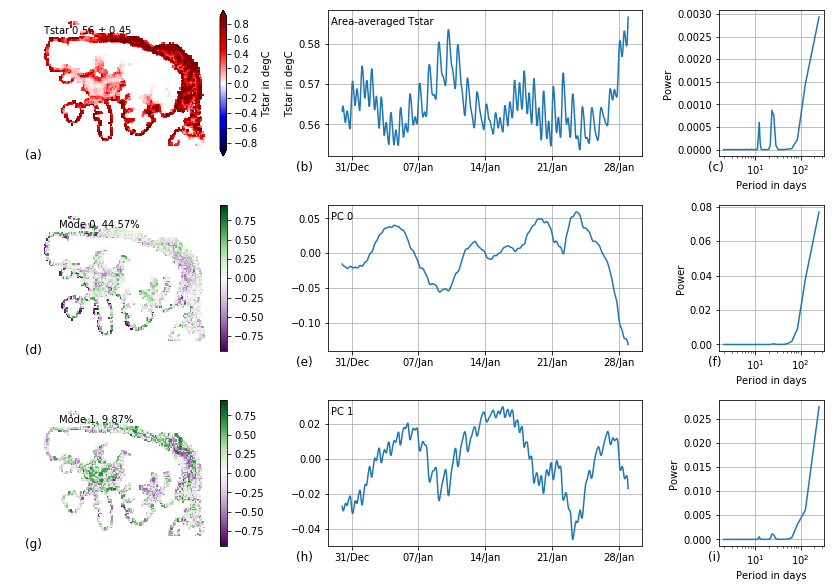

saving
PI
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


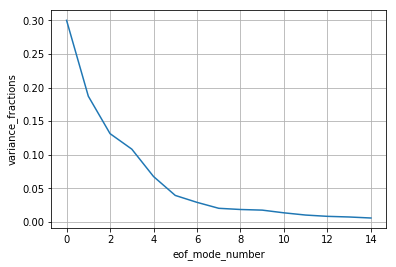

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


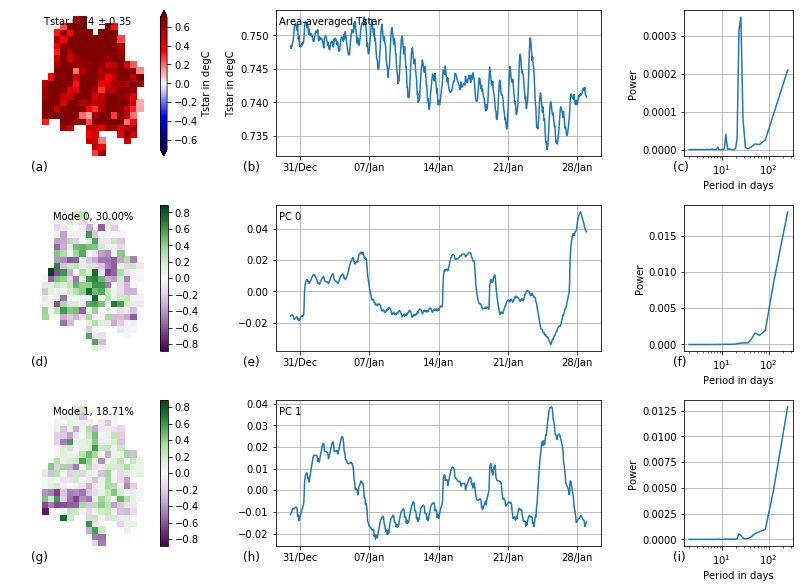

saving
Totten
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


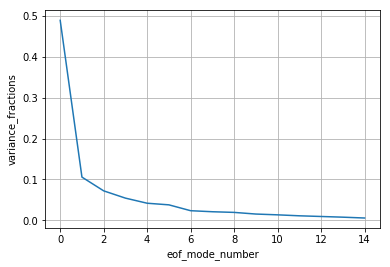

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


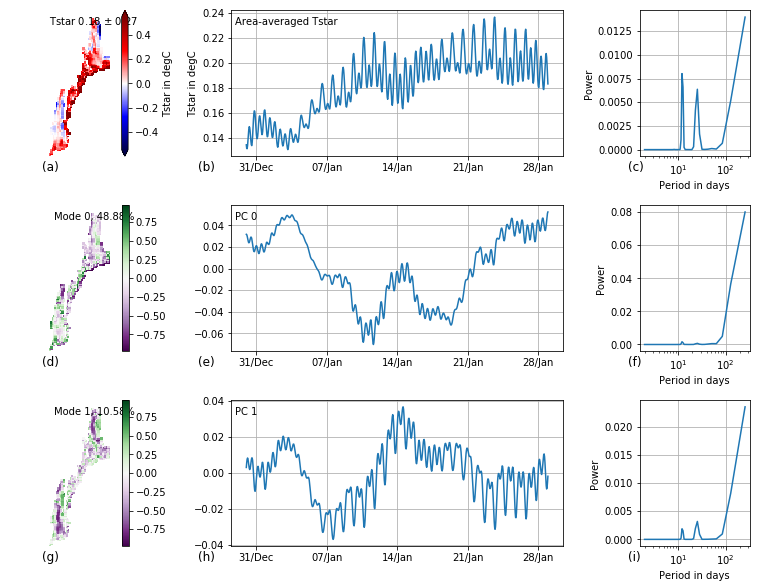

saving
Amery
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


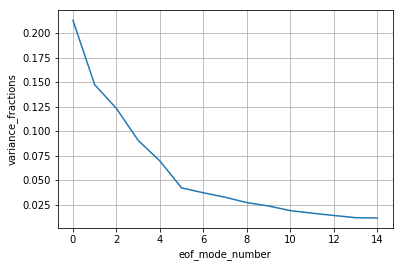

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


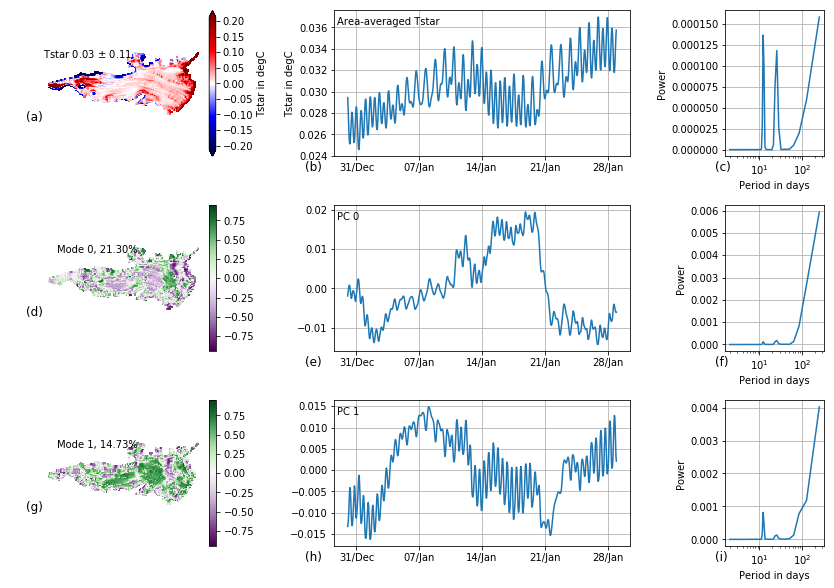

saving
Fimbul
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


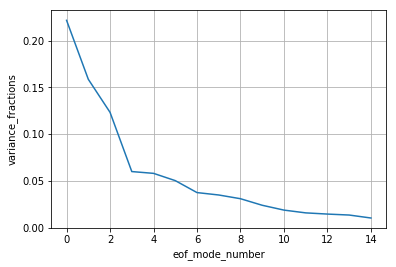

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


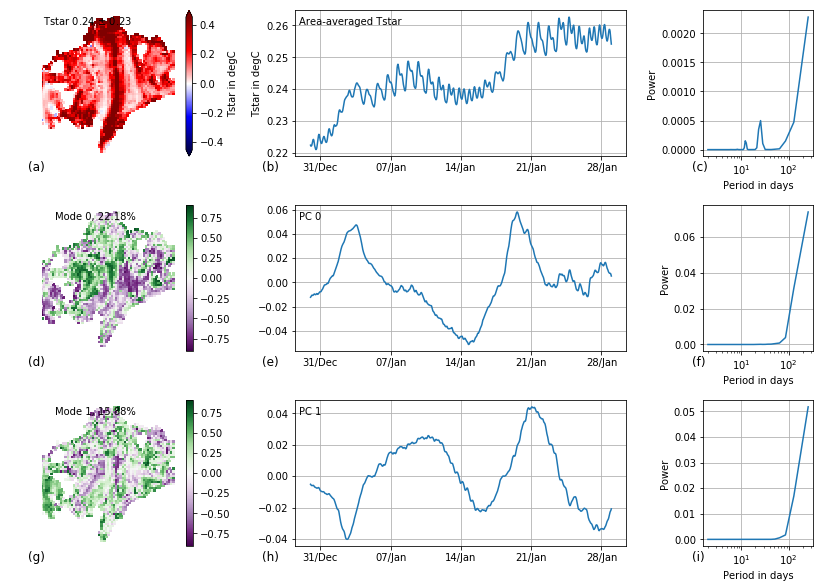

saving
LarsenC
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


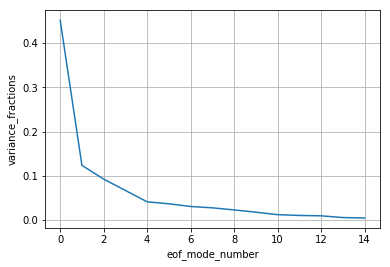

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


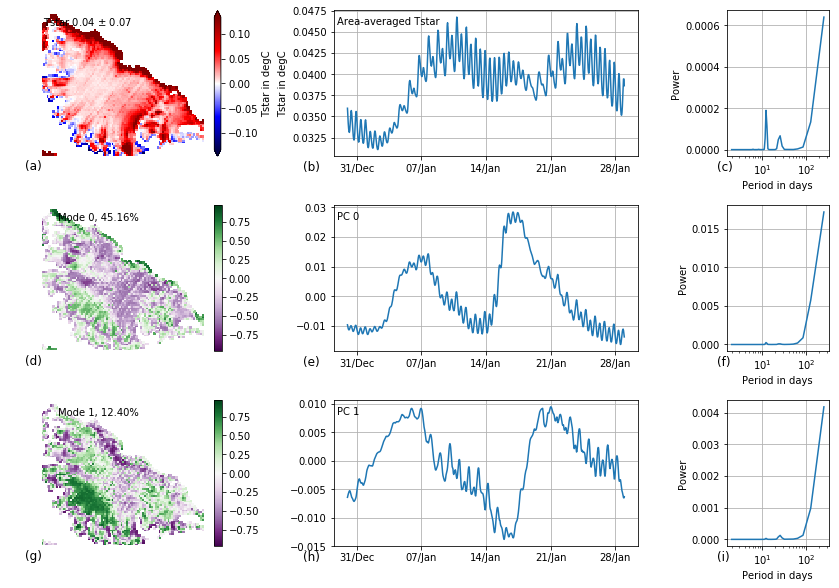

saving


In [6]:
for name,sel in sels.items():
    print(name)
    make_eof(avg_hr.Tstar,grd,sel,name+'_Tstar_')

## Ustar

FRIS
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


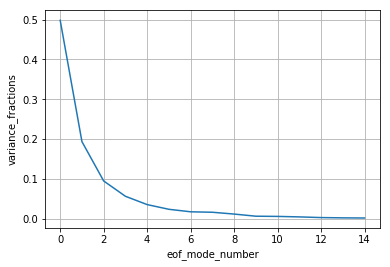

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


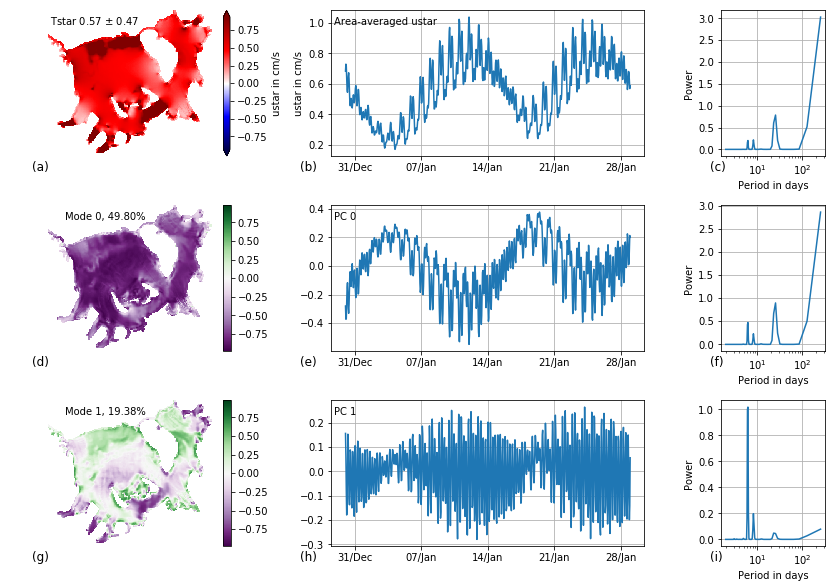

saving
Ross
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


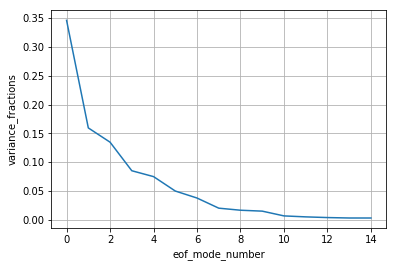

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


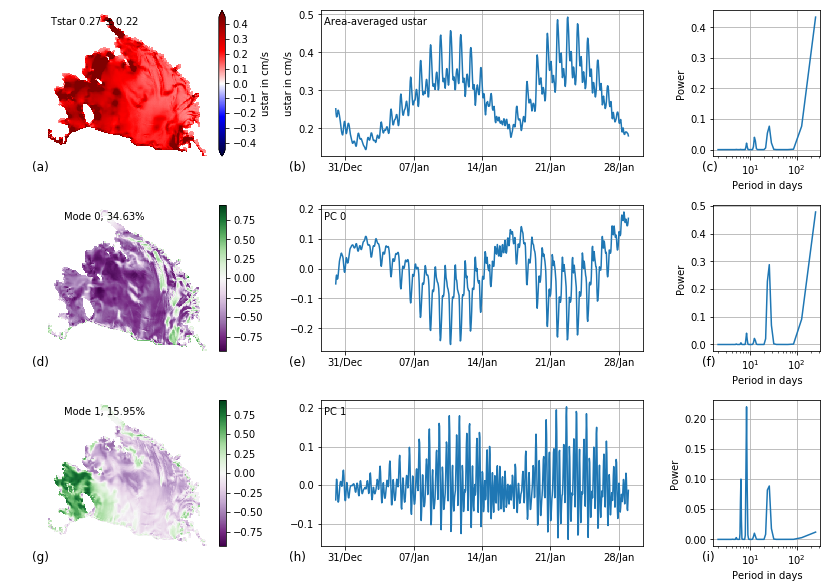

saving
GeorgeV
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


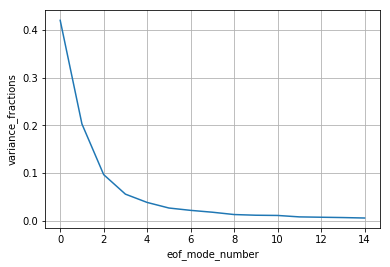

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


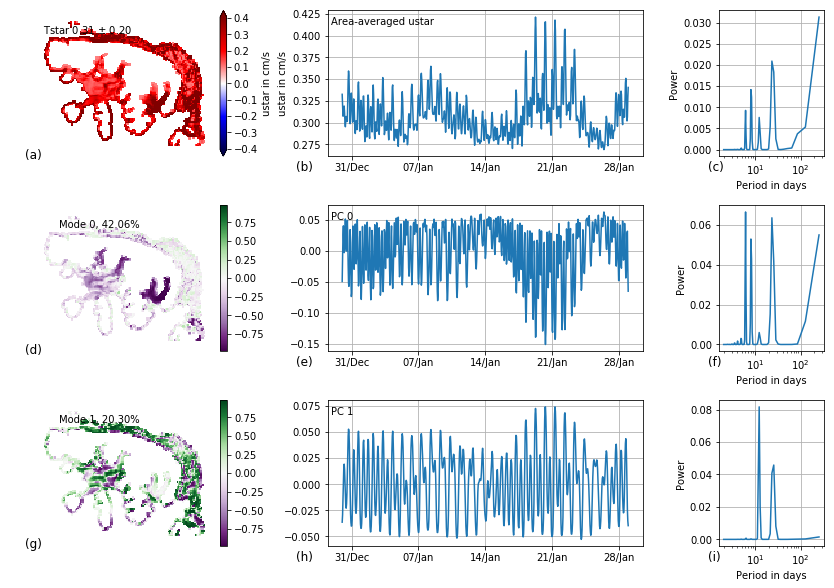

saving
PI
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


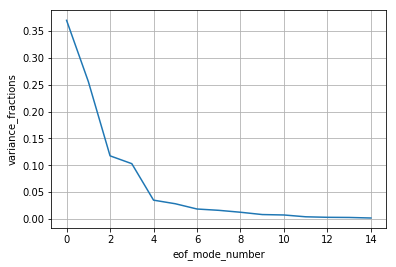

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


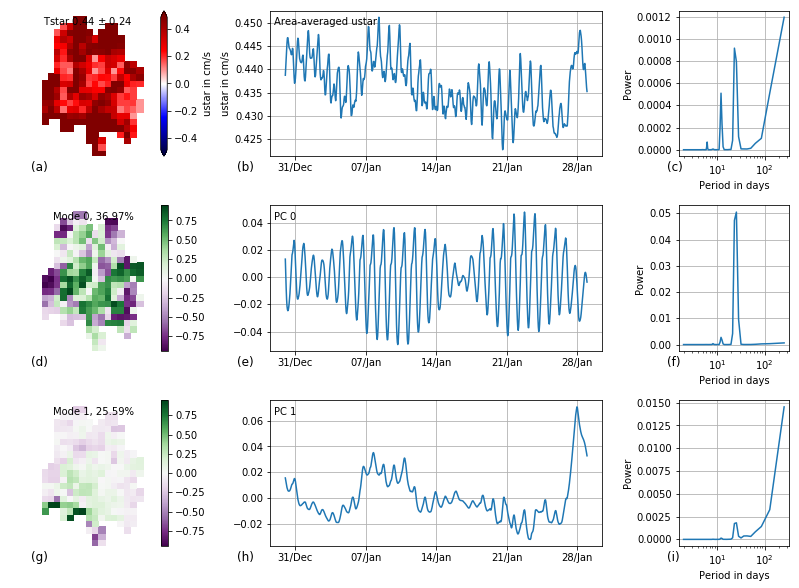

saving
Totten
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


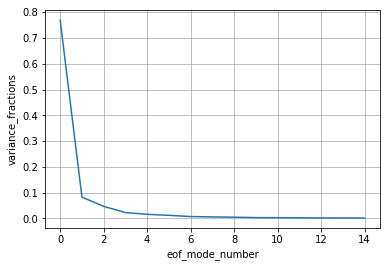

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


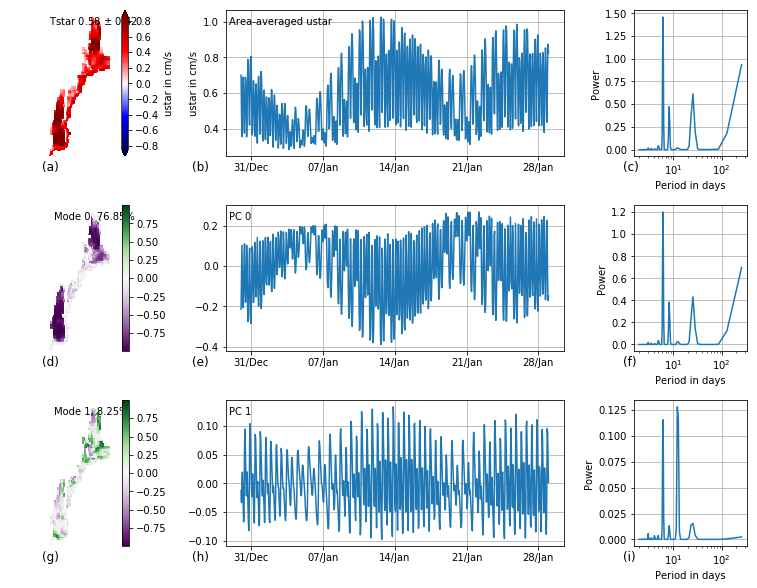

saving
Amery
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


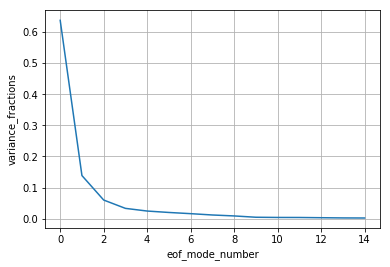

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


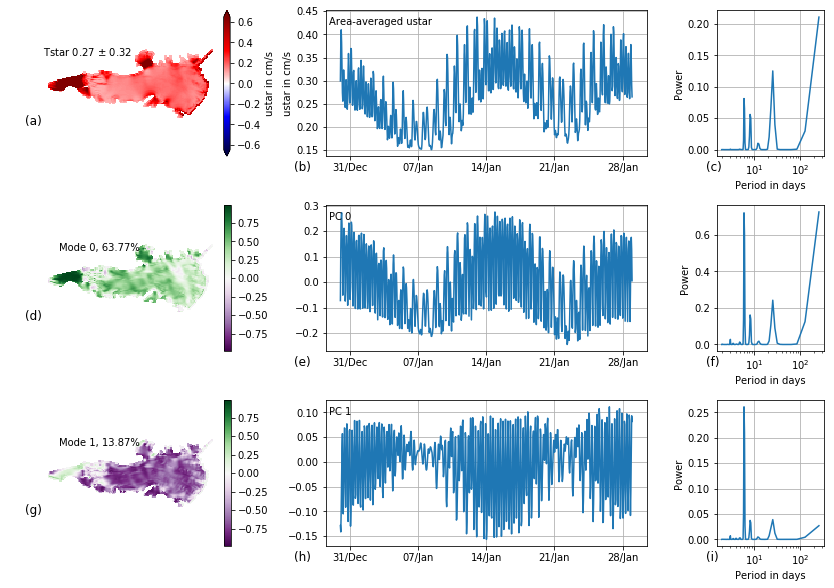

saving
Fimbul
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


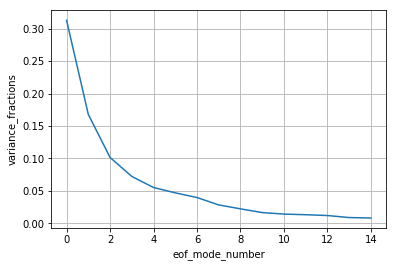

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


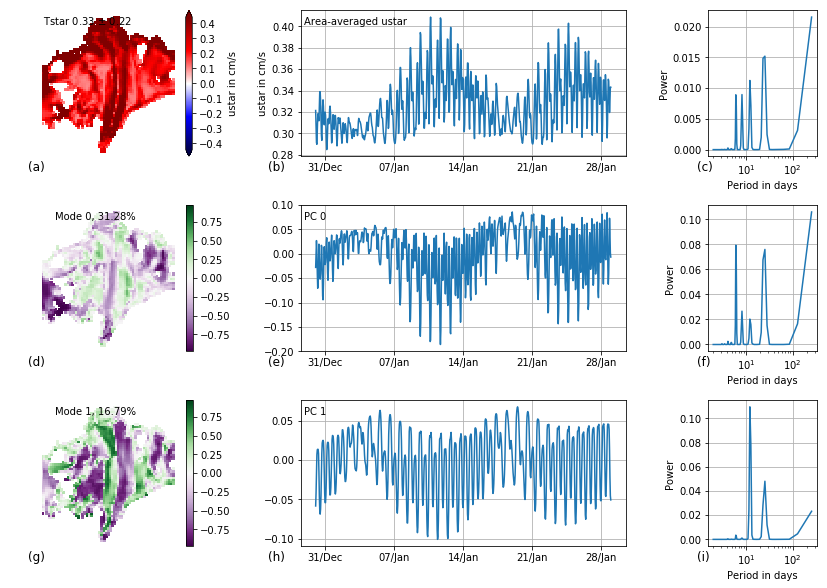

saving
LarsenC
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


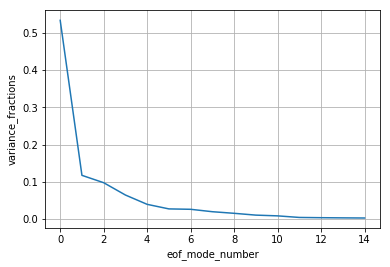

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


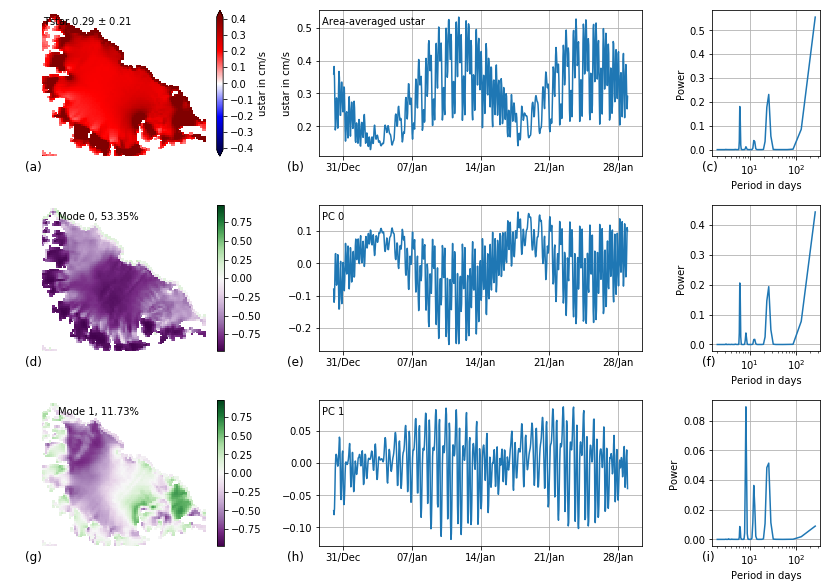

saving


In [10]:
for name,sel in sels.items():
    print(name)
    make_eof(avg_hr.ustar*100,grd,sel,name+'_ustar_')

# 365 days, 5 day averages, ice shelf samples, from 2km run, but downsampled to 4 km

In [13]:
from dask.distributed import Client

client = Client()
client

<Client: scheduler='tcp://127.0.0.1:53586' processes=16 cores=16>

In [14]:
file_path = os.path.join(raw_dir,'waom2','ocean_avg_0538-0610_m.nc')
m = xr.open_dataset(file_path,chunks={'xi_rho':117,'eta_rho':117}).m*s2a
m_reduced = m[:,::2,::2].load()

In [15]:
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

FRIS
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


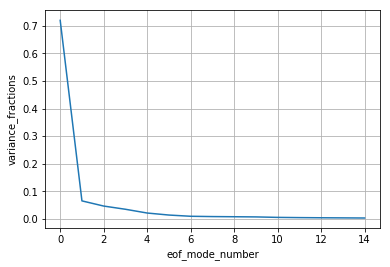

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

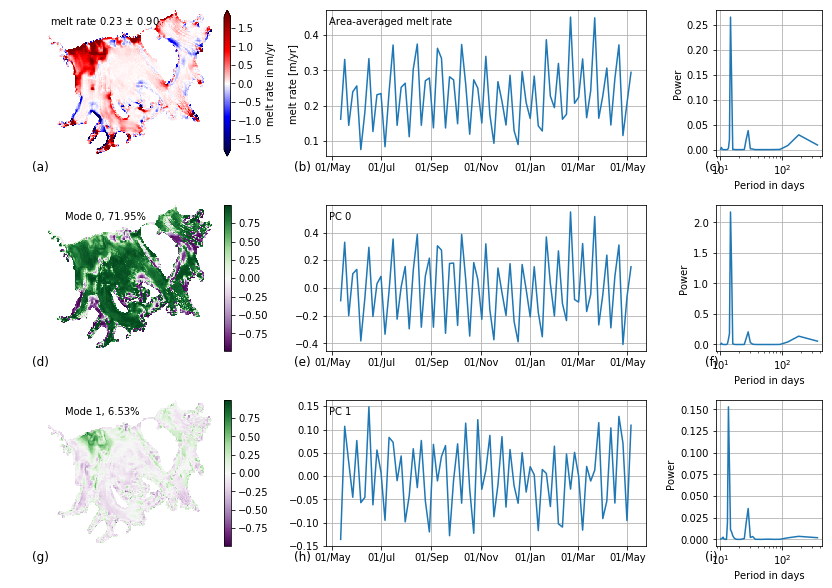

saving
Ross
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


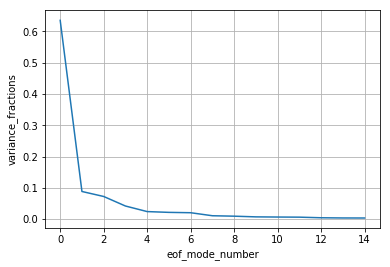

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

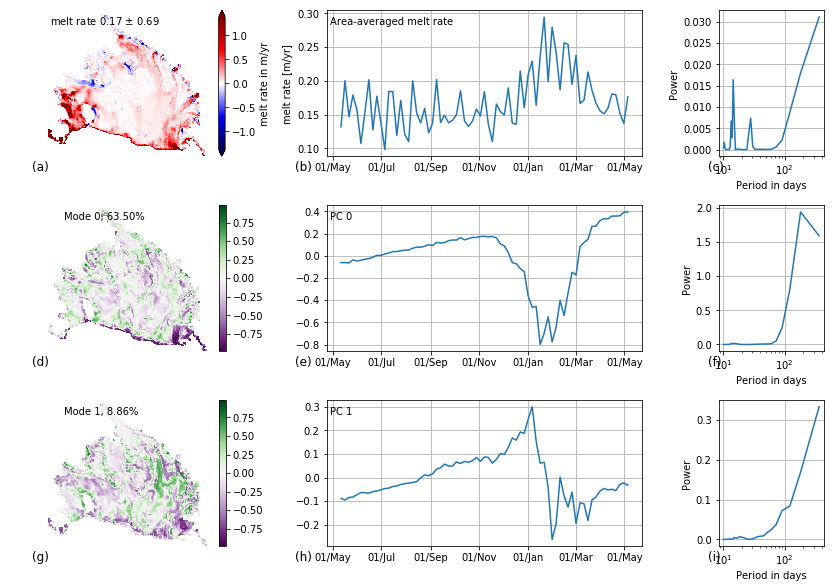

saving
GeorgeV
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


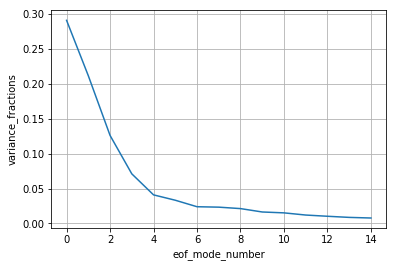

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

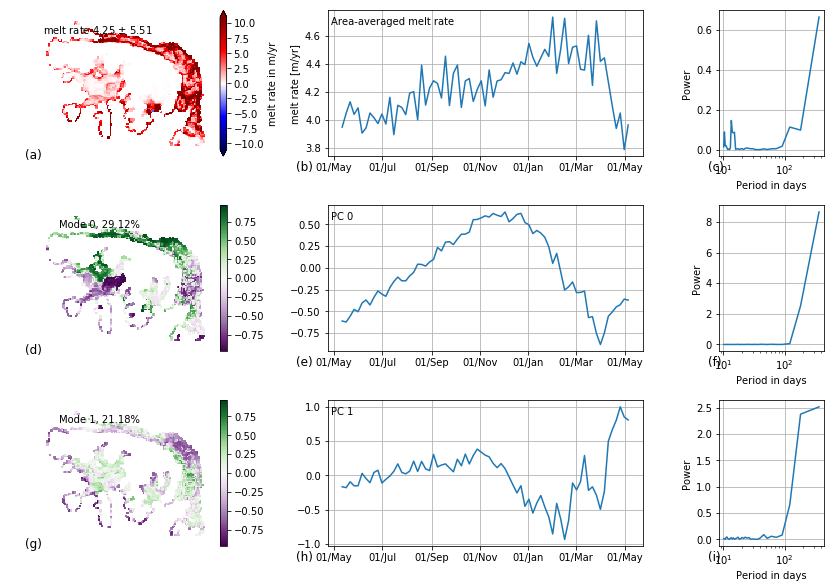

saving
PI
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


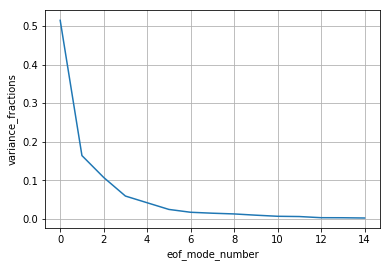

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

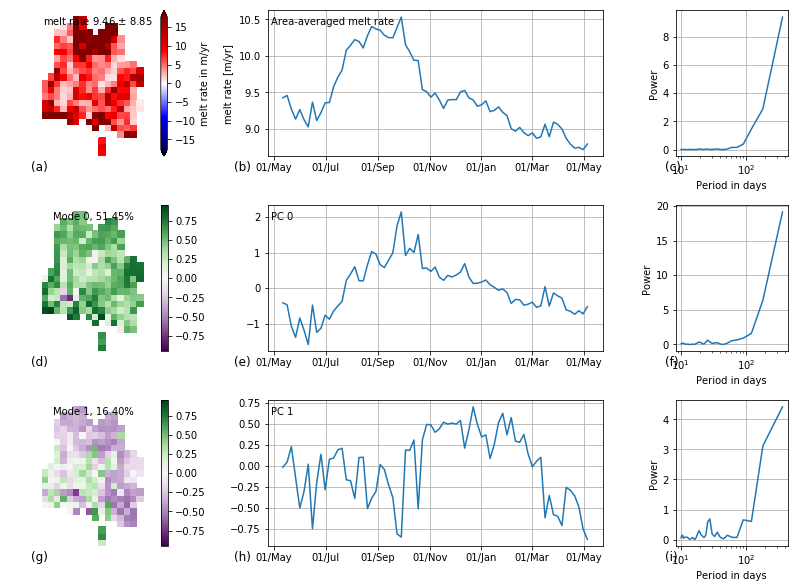

saving
Totten
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


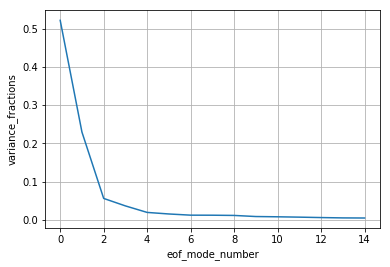

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

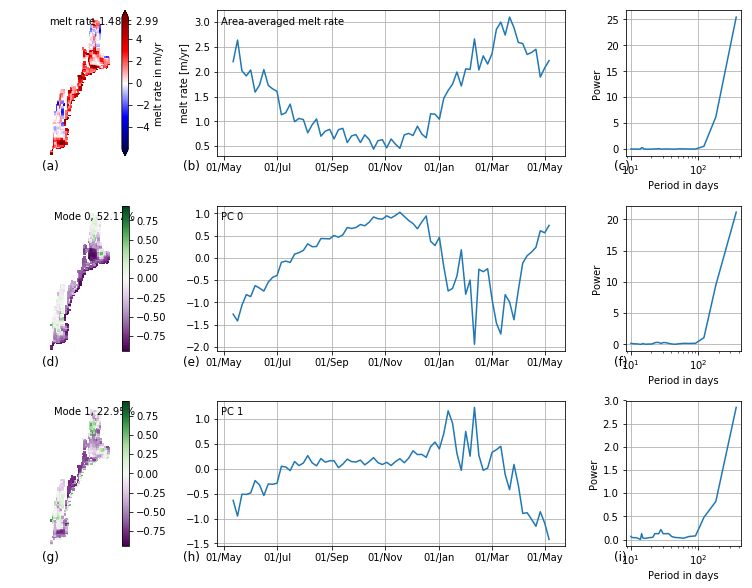

saving
Amery
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


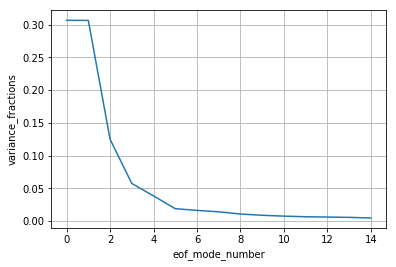

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

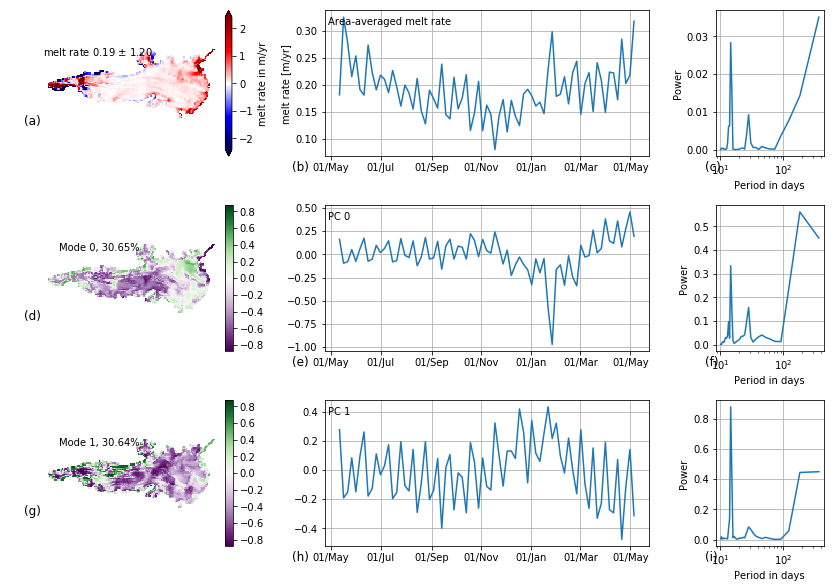

saving
Fimbul
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


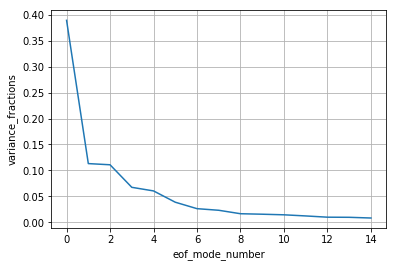

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

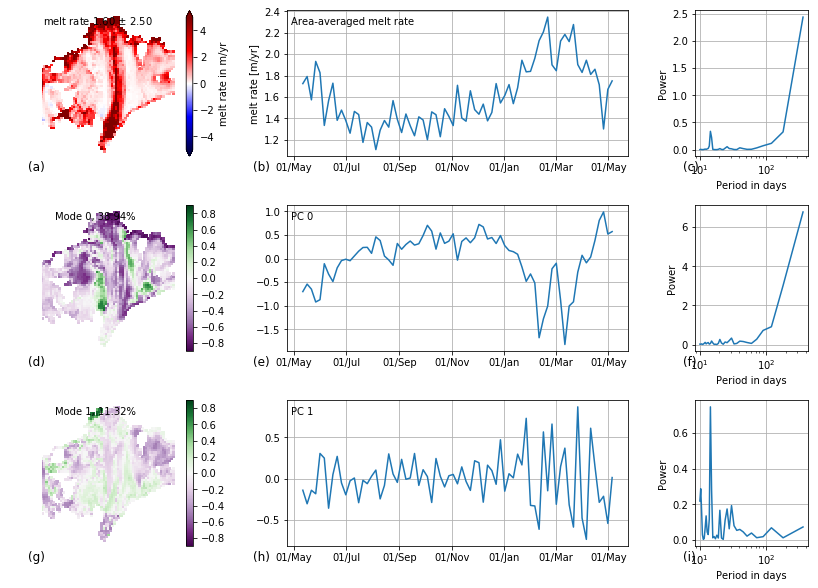

saving
LarsenC
subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


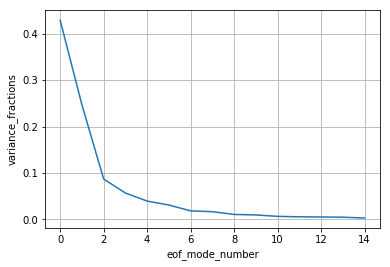

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

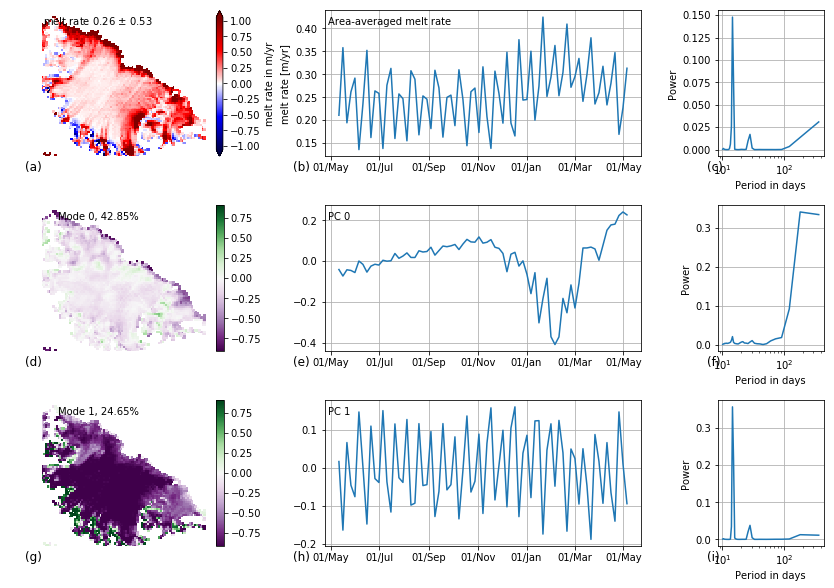

saving


In [16]:
for name,sel in sels.items():
    print(name)
    make_eof(m_reduced,grd,sel,name+'_annual')

# 365 days, 5 day averages, total antarctica 2km, but downsampled to 10 km 

In [4]:
from dask.distributed import Client

client = Client()
client

<Client: scheduler='tcp://127.0.0.1:55976' processes=16 cores=16>

In [20]:
m_reduced_10 = m[:,::5,::5].load()

In [21]:
grid_path = os.path.join(int_dir,'grd10_dV.nc')
grd = xr.open_dataset(grid_path)

In [22]:
sel = {'xi_rho':slice(None),'eta_rho':slice(None)}
name='TotalAntarctica'

subsetting
detrending
creating the eof solver
calculating and plotting the variance fractions


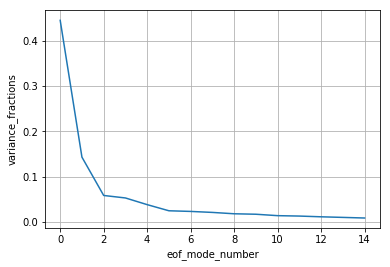

calculating the eofs and pcs
plotting


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(nperseg, input_length))
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 73, using nperseg = 73
  .format(

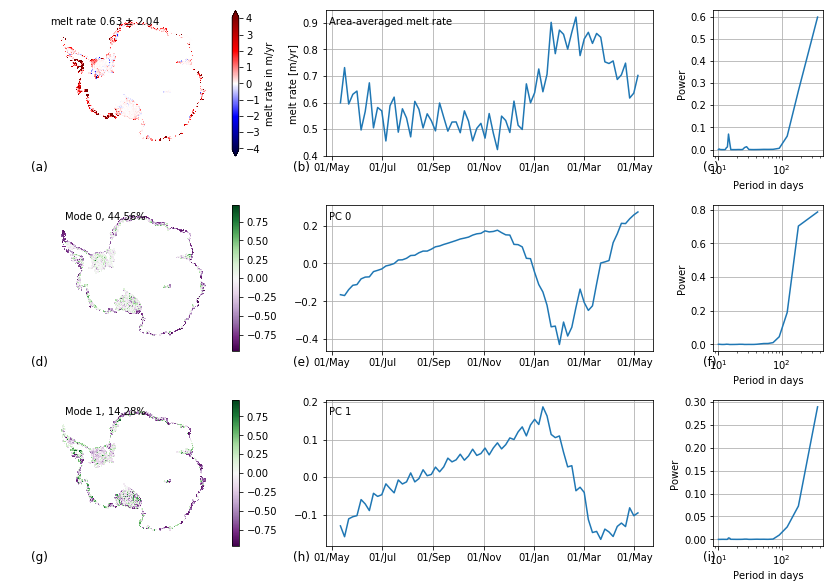

saving


In [23]:
make_eof(m_reduced_10,grd,sel,name+'_annual')